In [19]:
from itertools import product
from os import path

import matplotlib.pyplot as plt
import pandas as pd

In [20]:
files = [f'data/results-{i}.csv' for i in range(8)]
dfs = [pd.read_csv(f) for f in files]

results = pd.concat(dfs)

noise_distributions = results.noise_distribution.unique()
k_vals = results.k.unique()
m_vals = results.m.unique()
slopes = results.slope.unique()
intercepts = results.intercept.unique()
algs = results.columns[5:-1]
algs

Index(['all', 'partition', 'random_1', 'random_(10*km)', 'random_1000',
       'cooks', 'greedy', 'weight_rounding_50_50_50',
       'weight_rounding_10_50_50', 'weight_rounding_50_10_50',
       'weight_rounding_50_50_10'],
      dtype='object')

In [21]:
abs_suffix = '_abs'
squared_suffix = '_squared'

for alg in algs:
    results[alg + abs_suffix] = results[alg].abs()
    results[alg + squared_suffix] = results[alg].pow(2)

In [22]:
groups = results.groupby(['noise_distribution', 'slope', 'm', 'k', 'intercept'])

means = groups.mean().reset_index()
errors = groups.sem().reset_index()

In [23]:
noise_display = {
    'normal(0,.5^2)': r'$\mathcal{N}(0, .5^2)$',
    'uniform(-2,2)': r'$\mathcal{U}(-2, 2)$',
    'beta(2,2)-mirrored': r'$\beta(2, 2)$',
    'power-law(2)-mirrored': r'$PL(2)$',
}

alg_display = {
    'all': 'All',
    'partition': r'$F^{min}$',
    'opt': r'$F^{opt}$',
    'random_1': 'Random 1',
    'random_1000': 'Random 1000',
    'random_(10*km)': 'Random 10km',
    'cooks': 'Cooks',
    'greedy': 'Greedy',
    'weight_rounding_50_50_50': 'rounding_50_50_50',
    'weight_rounding_10_50_50': 'rounding_10_50_50',
    'weight_rounding_50_10_50': 'rounding_50_10_50',
    'weight_rounding_50_50_10': 'rounding_50_50_10',
}

In [53]:
def create_plot(square, noise_dist, slope, m, intercept, plot_legend=False, file_name=None, legend_file=None):
    plt.clf()
    fig, ax = plt.subplots()
    if square:
        suffix = squared_suffix
        ylabel = 'Mean squared bias'
    else:
        suffix = abs_suffix
        ylabel = 'Mean bias'

    means_filtered = means[(means.noise_distribution == noise_dist)
                           & (means.slope == slope)
                           & (means.m == m)
                           & (means.intercept == intercept)]
    errors_filtered = errors[(errors.noise_distribution == noise_dist)
                             & (errors.slope == slope)
                             & (errors.m == m)
                             & (errors.intercept == intercept)]

    x_vals = [str(i) for i in k_vals]

    for alg in algs:
        y_vals = means_filtered[alg + suffix]
        alg_errors = errors_filtered[alg + suffix]
        if y_vals.isnull().all():
            continue
        ax.errorbar(x_vals, y_vals, yerr=alg_errors, marker="s", label=alg_display[alg], capsize=4)

    font_size = 'xx-large'
    ax.set_xlabel("K value", fontsize=font_size)
    ax.set_ylabel(ylabel, fontsize=font_size)

    ax.set_title(fr'noise={noise_display[noise_dist]}, m={m}, $\beta_1$={slope}, $\beta_0$={intercept}', fontsize=font_size)

    if plot_legend:
        ax.legend(bbox_to_anchor=(1, 1), fontsize='large')

    ax.tick_params(which='minor', left=False)
    ax.set_yscale('log')

    if file_name is None:
        plt.show()
    else:
        file_path = path.join('plots', file_name)
        fig.savefig(file_path, bbox_inches='tight', format='pdf')

    if legend_file is not None:
        handles, labels = ax.get_legend_handles_labels()
        fig_legend = plt.figure(figsize=(2, 2))
        axi = fig_legend.add_subplot(111)
        fig_legend.legend(handles, labels, loc='center')
        axi.axis('off')
        fig_legend.savefig(path.join('plots', legend_file), bbox_inches='tight', format='pdf')

    plt.close(fig)

In [62]:
create_plot(False, noise_distributions[0], 1, 10, 0, plot_legend=True, file_name='2.pdf')

<Figure size 640x480 with 0 Axes>

In [53]:
for square, noise_dist, slope, m, legend in product([True], noise_distributions[:-1], slopes, m_vals, [True]):
    file_name = f'{"square" if square else "abs"}-noise={noise_dist[:noise_dist.index("(")]}-m={m}-slope={slope}{"" if legend else "-nolegend"}.pdf'
    create_plot(square, noise_dist, slope, m, file_name=file_name)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

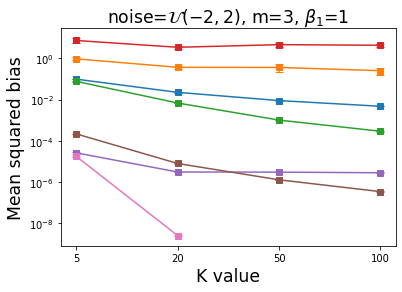

<Figure size 144x144 with 0 Axes>

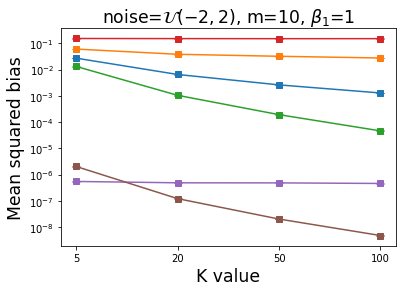

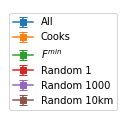

In [52]:
create_plot(True, noise_distributions[0], 1, 3, legend_file='legend-opt.pdf')
create_plot(True, noise_distributions[0], 1, 10, legend_file='legend-no-opt.pdf')
